Import all modules we will use for this notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

Below loads the dataset into memory

In [2]:
df = pd.read_csv('winequality-red.csv', sep=',')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Get basic information about each column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Examine the statistics for each feature

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Examine how strongly each feature correlates with quality, which will be our target feature

In [5]:
df.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

Note that none of the features seem to correlate too strongly with quality, which is good

Below we investigate the correlations of each feature with every other feature.<br>

In [6]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [7]:
df = df.drop(columns=['citric acid','density'])

Below we use seaborn to examine the correlations and covariances of each feature with every other feature.

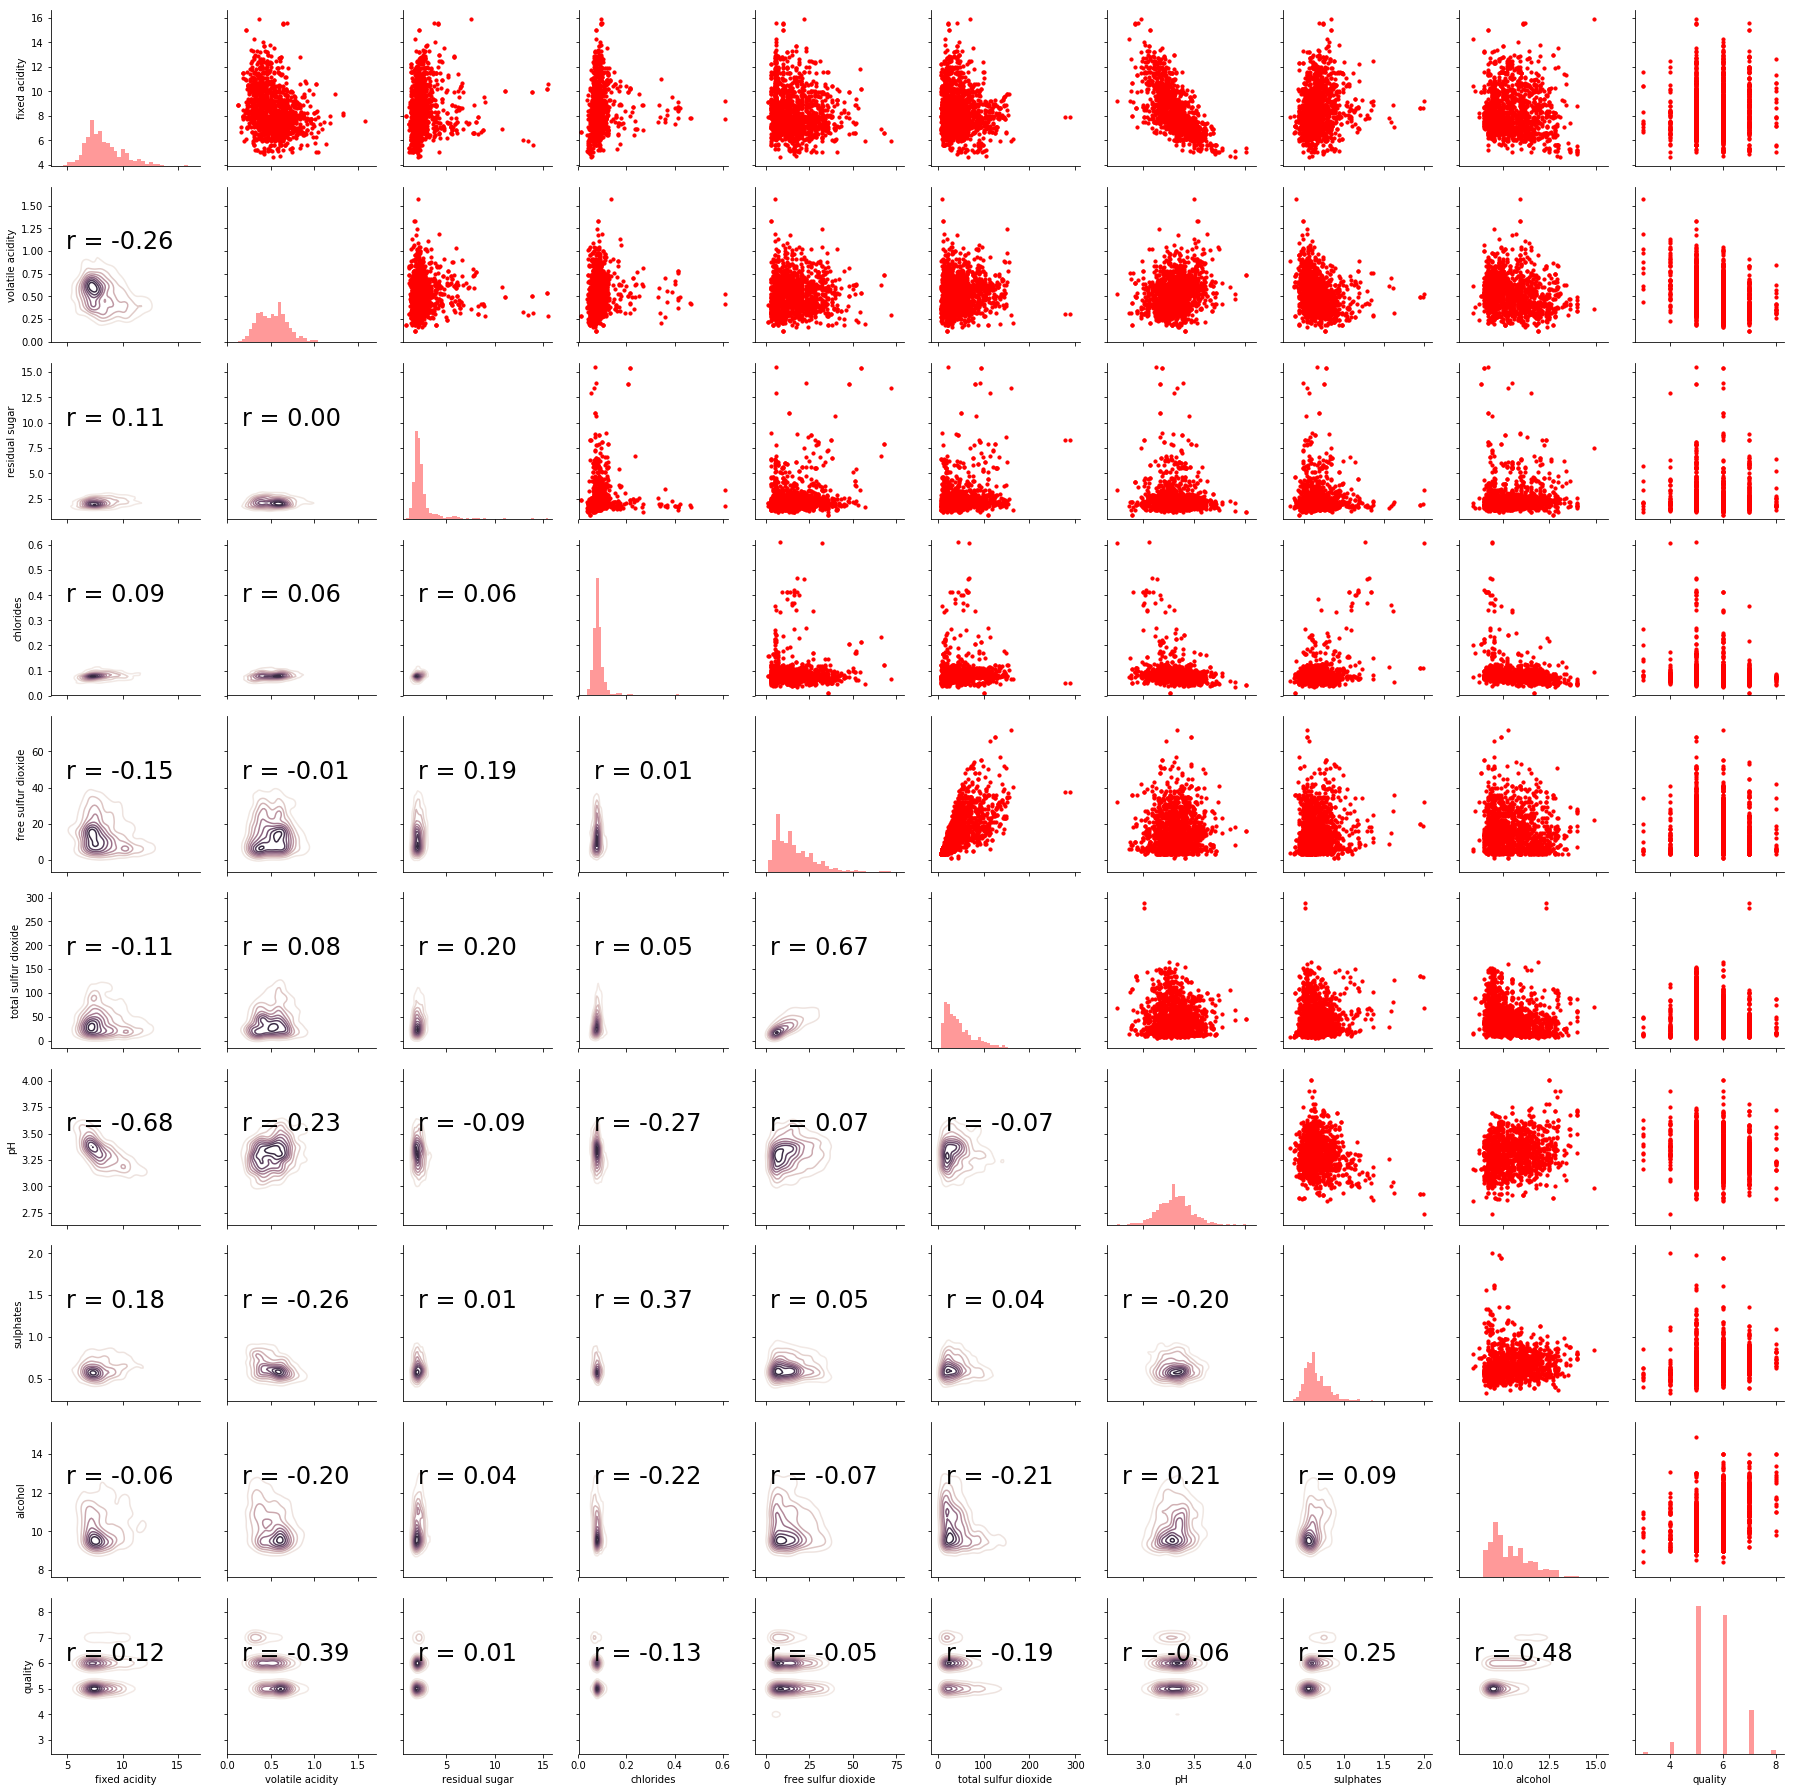

In [8]:
# Definition to calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .6), xycoords=ax.transAxes, size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

Below we separate quality into a separate vector and drop it from our feature matrix.

In [9]:
# Include all features except target
X = df.drop(columns='quality')

# Include only the target column
Y = df['quality']

print(X.shape)
print(Y.shape)

(1599, 9)
(1599,)


We now scale our feature matrix.

In [10]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Now split the data into testing and training datasets.

In [11]:
test_frac = 0.2
rand_seed = 42 # Seed random number generator

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_frac, random_state=rand_seed)

print(X_train.shape)
print(X_test.shape)

(1279, 9)
(320, 9)


We now do hyperparameter tuning to identify the best parameters to use.<br>
The parameters corresponding to the lowest mean squared error (MSE) are returned.

In [12]:
# max_iter is maximum number of iterations to go through
# alpha multiplies the regularization term (for alpha=0 we just have linear regression)
# learning rate being constant means that it is not updated through the descent
# l1_ratio The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty,
# l1_ratio=1 to L1. Defaults to 0.15.
# eta0 is the learning rate

param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
              'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],'eta0': [0.01, 0.001, 0.1]}

sgd = SGDRegressor()

sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=10)
sgd_cv.fit(X_train, Y_train)

print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Best Score (negative mean squared error): -0.431554
Optimal Hyperparameter Values:  {'alpha': 0.01, 'eta0': 0.001, 'l1_ratio': 0, 'learning_rate': 'constant', 'max_iter': 10000}


Below we use the above-found optimal hyperparameter values to create the best model, put below for convenience.<br>
Best Score (negative mean squared error): -0.432563<br>
Optimal Hyperparameter Values are below:
{'alpha': 0.01, 'eta0': 0.001, 'l1_ratio': 0.5, 'learning_rate': 'constant', 'max_iter': 10000}

We now use these optimal parameters and see how well the fit is with our training set.

In [13]:
max_iter_opt = 10000
learning_rate_opt = 'constant'
eta0_opt = 0.001 # learning rate
penalty_opt = 'elasticnet' # Note this was not determined through the cross-validation gridsearch
l1_ratio_opt = 0.5
alpha_opt = 0.01 # Reguularization Parameter

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt, eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# This trains the created model
lin_reg_sgd.fit(X_train, Y_train)

# Report the intercept for our model
print("Intercept: \n", lin_reg_sgd.intercept_)

# Report all other coefficients for our model
print("Coefficients: \n", lin_reg_sgd.coef_)

# Report number of iterations model ran through (note max allowed is given above)
print("Number of Iterations: \n", lin_reg_sgd.n_iter_)

print("\n----------------------------- Model Evaluation -----------------------------")

# Creates and saves predictions for our target column
Y_train_predicted_sgd = lin_reg_sgd.predict(X_train)

# Calculate and display mean squared error for training data
print("Mean squared error: %.2f" % mean_squared_error(Y_train, Y_train_predicted_sgd))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(Y_train, Y_train_predicted_sgd))

Intercept: 
 [5.62834006]
Coefficients: 
 [ 0.00727639 -0.16626937  0.         -0.0882439   0.05053954 -0.1063969
 -0.05660416  0.12646788  0.29671581]
Number of Iterations: 
 10000

----------------------------- Model Evaluation -----------------------------
Mean squared error: 0.43
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.35


The above is a not the best r^2 score. Note that I found if I remove a few features which seem to covary a bit too much with the others we do not see a significant improvement.<br>
Perhaps investigating more parameters would see improvement, but from the additional investigation we employed we did not see improvement.<br>
This may just be the best fit we can get for this dataset.

We will now evaluate this model using the reserved test data

In [14]:
# Make prediction using the test data
Y_test_predicted = lin_reg_sgd.predict(X_test)


print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predicted))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(Y_test, Y_test_predicted))

Mean squared error: 0.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.40


This result is interesting. Our MSE even lower than it was with the training set. We are thus not overfitting our model.<br>
However, I would not have expectd the MSE to be lower on the test than the train set. I do not see a mistake we have made, and will thus simply note this as a curiosity.

We will now choose the optimal degree (Model Complexity) for our polynomial regression

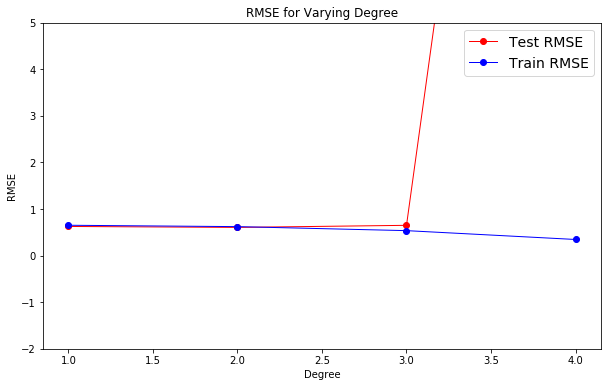

In [15]:
degreeList = [1,2,3,4] # Degrees of polynomials for fitting to to check

mse_train, mse_test = [], []

for degree in degreeList:
    # Create model for current degree polynomial being considered
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
    
    # Fit model using the training data for current degree of polynomial
    model.fit(X_train, Y_train)
       
    # Make prediction for both training and testing datasets
    Y_train_predicted = model.predict(X_train)
    Y_test_predicted = model.predict(X_test)
    
    # These keep track of MSE for testing and training datasets for each polynomial order considered
    mse_train.append(mean_squared_error(Y_train, Y_train_predicted))
    mse_test.append(mean_squared_error(Y_test, Y_test_predicted))
    
# Below plots the “rmse vs. degree”
plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_test), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.ylim(bottom = -2, top=5) # Adjust the y range to better understand which order of polynomial really becomes a problem
plt.show()

From the above we can see that the optimal order of polynomial to consider is probably 2 because from the above plot we can see the red curve around order 3, but it is completely overlapped with order 2. Thus, the highest complexity our model can provide while still providing a very small generalization error is order 2, although the plot shows that perhaps a polynomial of order 3 is also acceptable. I would suggest order 2.

The above finding may explain why our r^2 variance score is so bad for problem 2. If you look at the coefficients you will see that we are putting quite a bit of emphasis on higher order terms.

We now use the learning curves to determine the optimal number of elements to put in our training set.

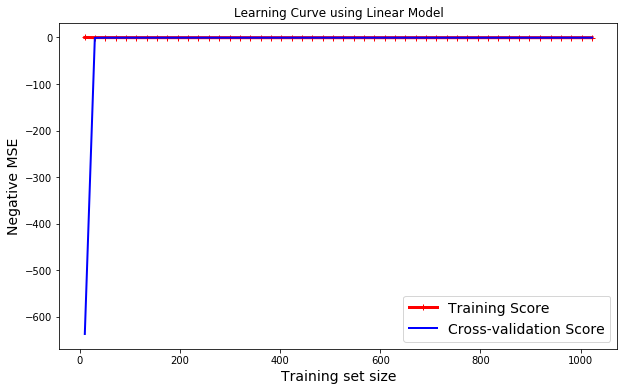

In [16]:
# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, Y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve using Linear Model")
plt.show()

The below is plotting the same data. We have just adjusted the y-scale to better see the smaller scale effects.

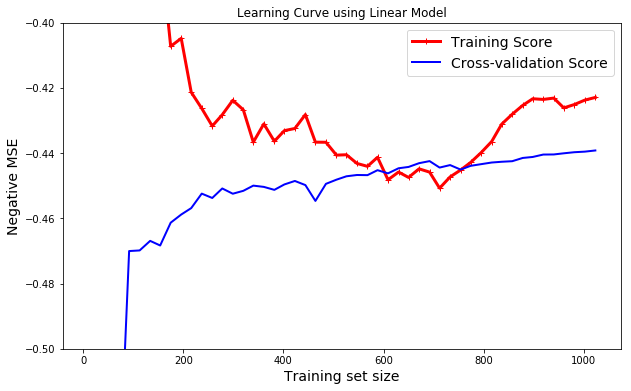

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve using Linear Model")
plt.ylim(bottom = -0.5, top=-0.4)
plt.show()

We now examine the learning curve if we consider a 4th order polynomial fit.

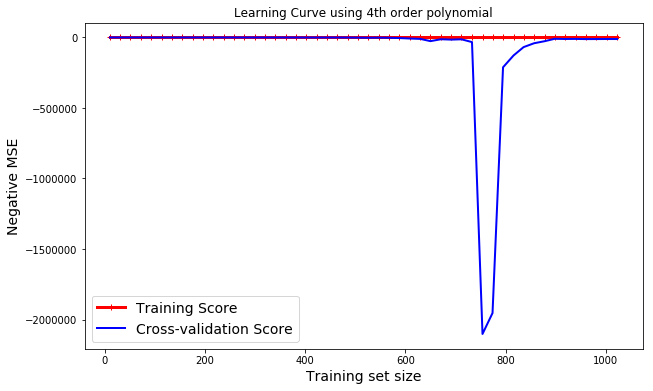

In [18]:
poly_degree = 4

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)

train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, Y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve using 4th order polynomial")
plt.show()

The below is plotting the same data. We have just adjusted the y-scale to better see the smaller scale effects.

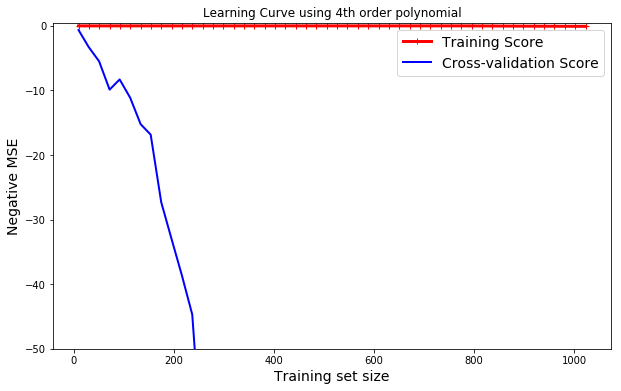

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve using 4th order polynomial")
plt.ylim(bottom = -50, top=0.5)
plt.show()

The above clearly shows that there is no time at which a 4th order polynomial gives good generalization error.

As shown above, using a linear model there is only a small range of training samples over which the generalization error is very small. Even when we increase the number of training samples we see that the generalization error does not get better, but actually increases. This therefore looks like this model is underfitting, although overall it doesn't look too bad.

Using a 4th order polynomial has no training set size over which the generalization error is very low. It is always overfitting the data, and thus gets worse with adding more and more data.